In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [10]:
import numpy as np

def calculate_conflicts(graph, coloring):
    conflicts = 0
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    for edge in graph.edges():
        u, v = edge
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)
        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                conflicts += 1
        
        for j in range(len(v_edges)):
            if edge_color[v_edges[j]] == edge_color[edge]:
                conflicts += 1
    return conflicts // 2

def ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_nodes  # Initially set the number of colors to the number of nodes
    
    # Initialize pheromone matrix
    pheromone_matrix = np.ones((num_edges, num_colors))
    
    # Initialize best coloring and its value
    best_coloring = np.zeros(num_edges, dtype=int)
    best_value = float('inf')
    
    for iteration in range(num_iterations):
        # Initialize ant solutions
        ant_solutions = np.zeros((num_ants, num_edges), dtype=int)
        
        # Construct ant solutions
        for ant in range(num_ants):
            for edge in range(num_edges):
                probabilities = np.zeros(num_colors)
                if graph.has_node(edge):  # Check if edge is a valid node
                    for color in range(num_colors):
                        if is_valid_coloring(graph, ant_solutions[ant]):
                            probabilities[color] = (pheromone_matrix[edge][color] ** alpha) * ((1 / (graph.degree(edge) + 1)) ** beta)
                                 
                sum_probabilities = np.sum(probabilities)
                if sum_probabilities == 0:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                else:
                    probabilities /= sum_probabilities
                if num_colors > 0:
                    ant_solutions[ant][edge] = np.random.choice(range(num_colors), p=probabilities)


        
        # Update pheromone matrix
        pheromone_matrix *= (1 - evaporation_rate)
        for ant in range(num_ants):
            if is_valid_coloring(graph, ant_solutions[ant]):
                value = calculate_conflicts(graph, ant_solutions[ant])
                if value < best_value:
                    best_value = value
                    best_coloring = ant_solutions[ant]
                for edge in range(num_edges):
                    pheromone_matrix[edge][ant_solutions[ant][edge]] += pheromone_deposit / (value + 1e-10)
        
        
        # Update number of colors if a better coloring is found
        if best_value < num_colors:
            num_colors = best_value
    
    return best_coloring, best_value, len(np.unique(best_coloring))


Running test graph_3_edges.txt...
Best Coloring: [1 2 0]
Best Value: 0
Number of Colors: 3
[1 2 0]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


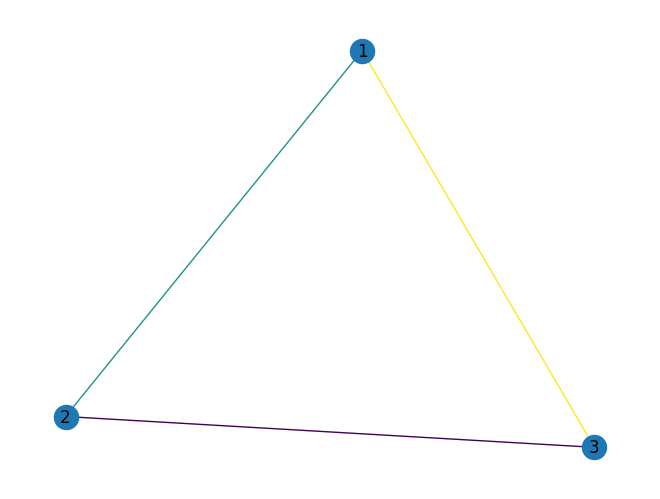

Time taken: 0.0365290641784668 seconds

Running test graph_5_edges.txt...
Best Coloring: [0 3 1 3 0]
Best Value: 0
Number of Colors: 3
[0 3 1 3 0]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


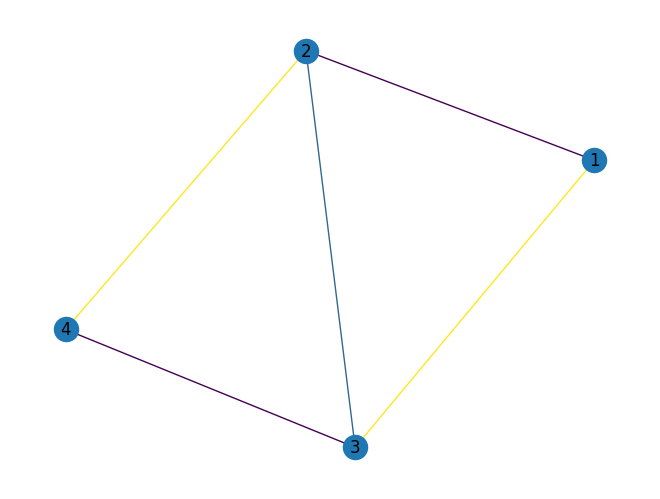

Time taken: 0.05340743064880371 seconds

Running test graph_5_edges_2.txt...
Best Coloring: [1 3 0 0 2]
Best Value: 0
Number of Colors: 4
[1 3 0 0 2]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 4


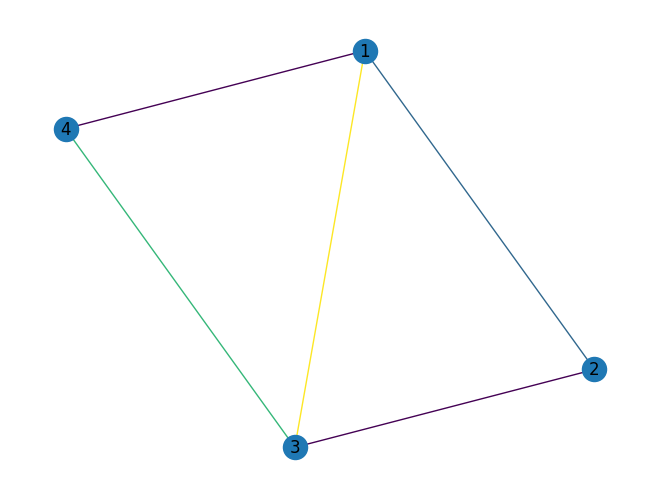

Time taken: 0.061777353286743164 seconds

Running test graph_6_edges.txt...
Best Coloring: [2 5 4 0 3 2]
Best Value: 0
Number of Colors: 5
[2 5 4 0 3 2]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


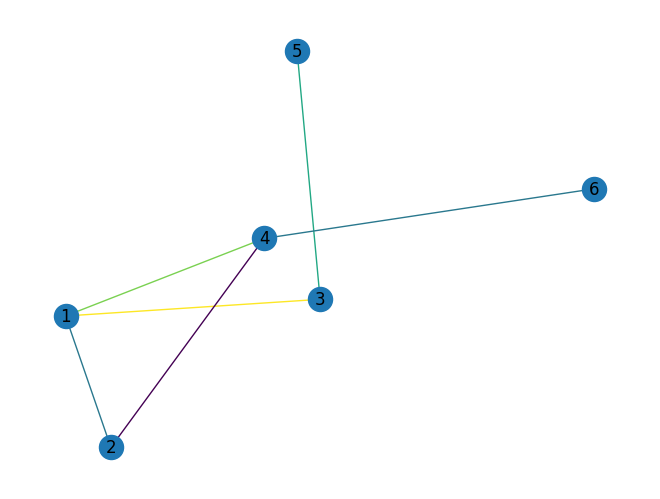

Time taken: 0.06777691841125488 seconds

Running test graph_7_edges.txt...
Best Coloring: [4 3 1 2 0 4 0]
Best Value: 0
Number of Colors: 5
[4 3 1 2 0 4 0]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


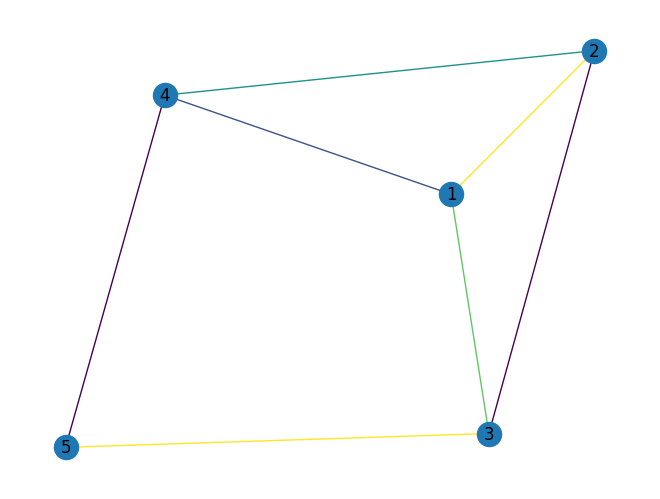

Time taken: 0.06946277618408203 seconds

Running test graph_7_edges_2.txt...
Best Coloring: [4 3 0 2 1 0 4]
Best Value: 0
Number of Colors: 5
[4 3 0 2 1 0 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


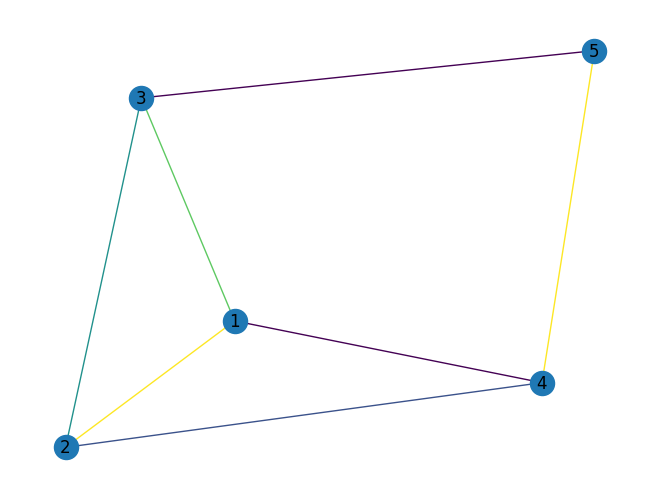

Time taken: 0.11581730842590332 seconds

Running test graph_7_edges_3.txt...
Best Coloring: [0 6 3 4 1 6 6]
Best Value: 0
Number of Colors: 5
[0 6 3 4 1 6 6]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


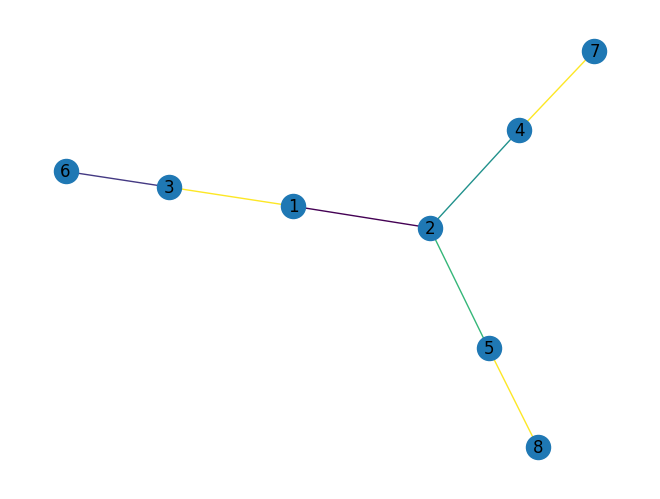

Time taken: 0.08423900604248047 seconds

Running test graph_8_edges.txt...
Best Coloring: [7 0 8 7 5 2 3 7]
Best Value: 0
Number of Colors: 6
[7 0 8 7 5 2 3 7]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


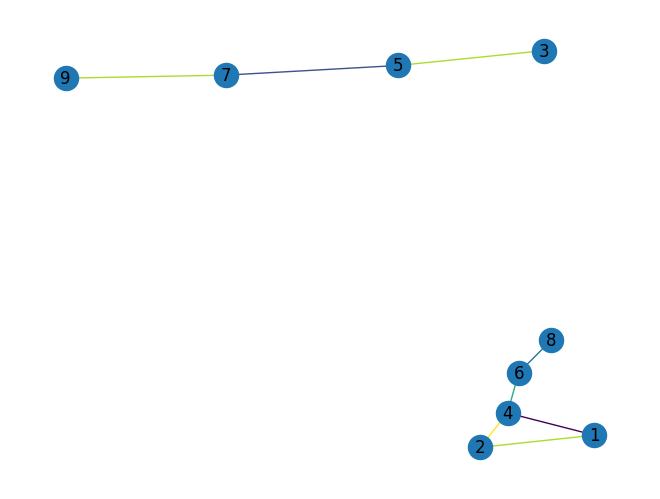

Time taken: 0.09975695610046387 seconds

Running test graph_9_edges.txt...
Best Coloring: [0 3 1 4 2 0 2 1 4]
Best Value: 0
Number of Colors: 5
[0 3 1 4 2 0 2 1 4]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


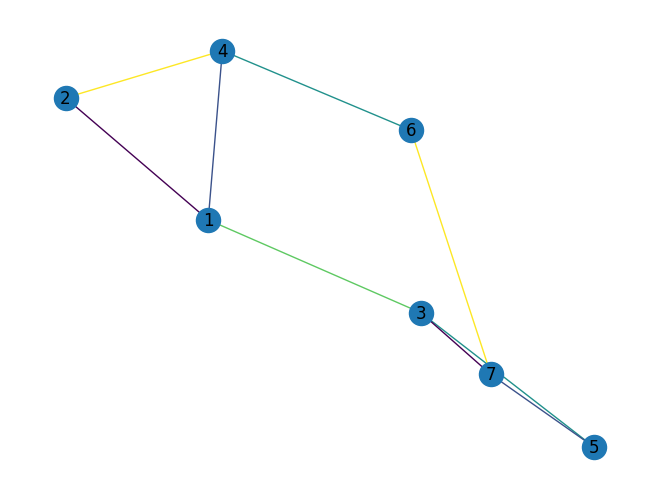

Time taken: 0.11133289337158203 seconds

Running test graph_9_edges_2.txt...
Best Coloring: [0 5 4 7 4 7 2 3 3]
Best Value: 0
Number of Colors: 6
[0 5 4 7 4 7 2 3 3]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


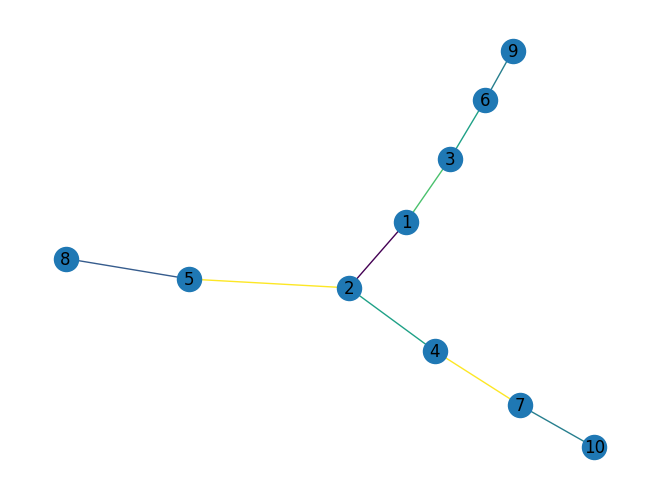

Time taken: 0.11114144325256348 seconds

Running test graph_10_edges.txt...
Best Coloring: [ 6 10  1 10  4  5  1  2  3  0]
Best Value: 0
Number of Colors: 8
[ 6 10  1 10  4  5  1  2  3  0]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 8


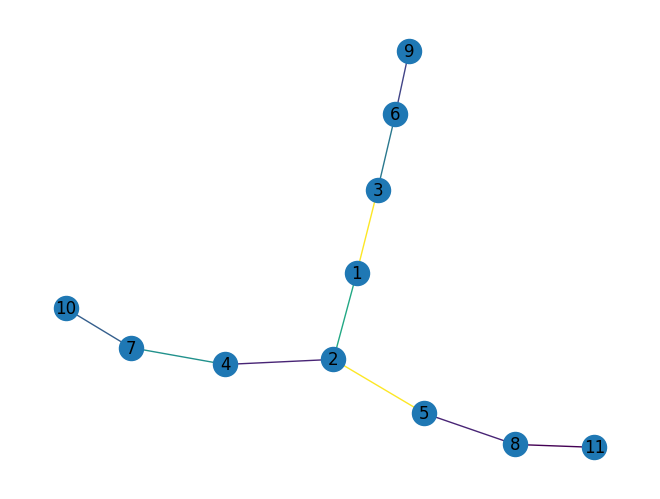

Time taken: 0.12919187545776367 seconds

Running test graph_10_edges_2.txt...
Best Coloring: [2 1 4 0 5 0 1 3 4 1]
Best Value: 0
Number of Colors: 6
[2 1 4 0 5 0 1 3 4 1]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 6


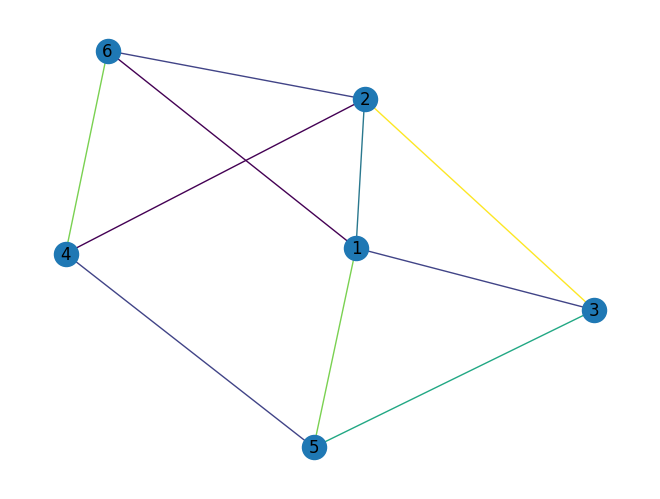

Time taken: 0.15837645530700684 seconds

Running test graph_10_edges_3.txt...
Best Coloring: [2 4 6 4 8 5 7 1 6 5]
Best Value: 0
Number of Colors: 7
[2 4 6 4 8 5 7 1 6 5]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


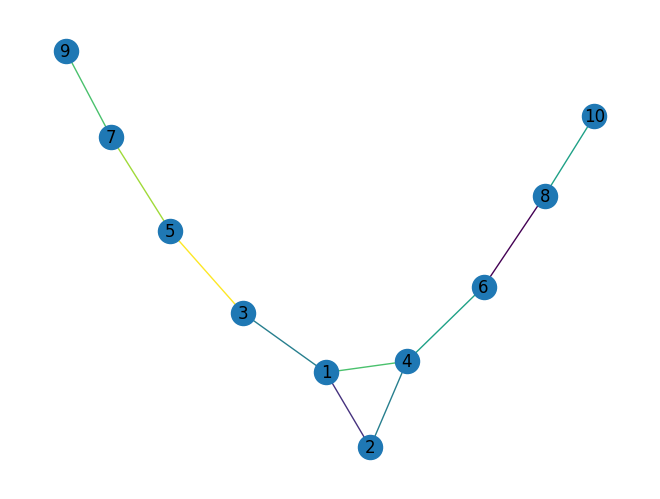

Time taken: 0.12239766120910645 seconds

Running test graph_11_edges.txt...
Best Coloring: [6 2 5 1 0 2 3 1 4 0 5]
Best Value: 0
Number of Colors: 7
[6 2 5 1 0 2 3 1 4 0 5]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


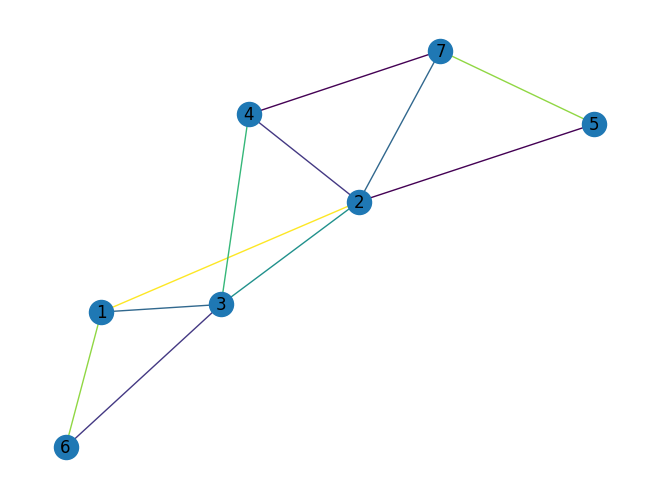

Time taken: 0.21641969680786133 seconds

Running test graph_11_edges_2s.txt...
Best Coloring: [1 0 5 0 5 4 1 7 4 4 1]
Best Value: 0
Number of Colors: 5
[1 0 5 0 5 4 1 7 4 4 1]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 5


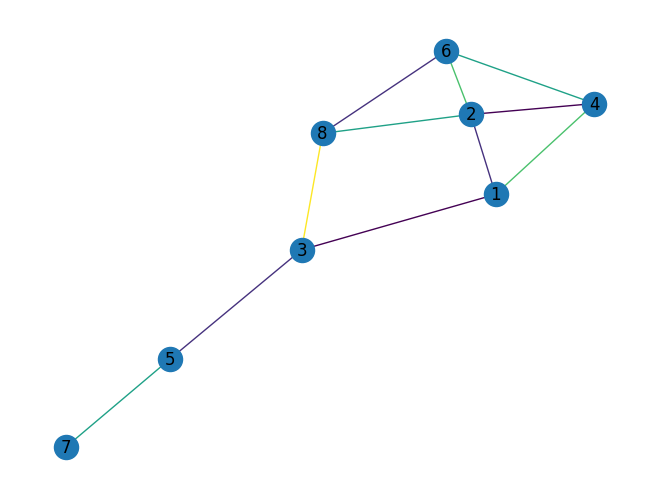

Time taken: 0.162217378616333 seconds

Running test graph_11_edges_3.txt...
Best Coloring: [ 4  3  9 10  7  3  4  4  9  0  8]
Best Value: 0
Number of Colors: 7
[ 4  3  9 10  7  3  4  4  9  0  8]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


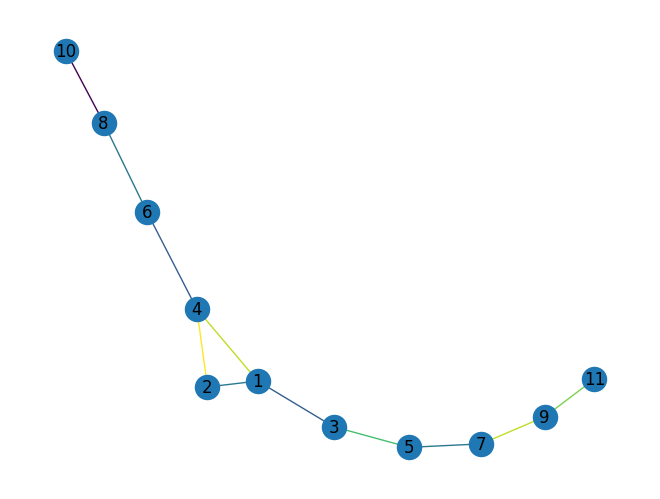

Time taken: 0.1574409008026123 seconds

Running test graph_11_edges_4.txt...
Best Coloring: [ 4  5  3  7 11  6  2  9 11 10  1]
Best Value: 0
Number of Colors: 10
[ 4  5  3  7 11  6  2  9 11 10  1]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 10


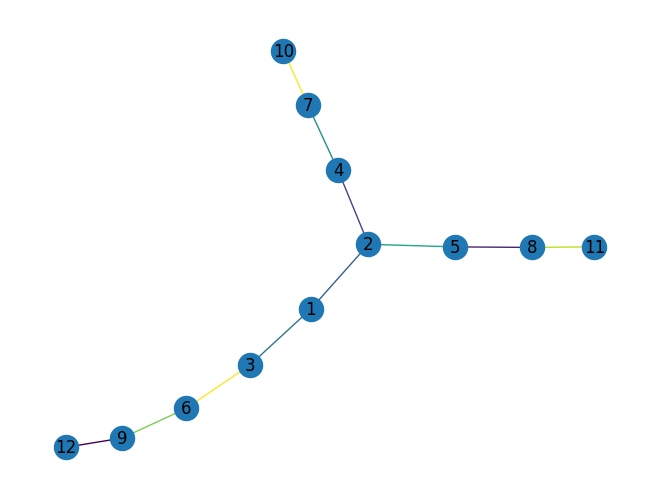

Time taken: 0.16019916534423828 seconds

Running test graph_12_edges.txt...
Best Coloring: [ 8  2  7  9  5  4  1  9 11  3  5  4]
Best Value: 0
Number of Colors: 9
[ 8  2  7  9  5  4  1  9 11  3  5  4]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


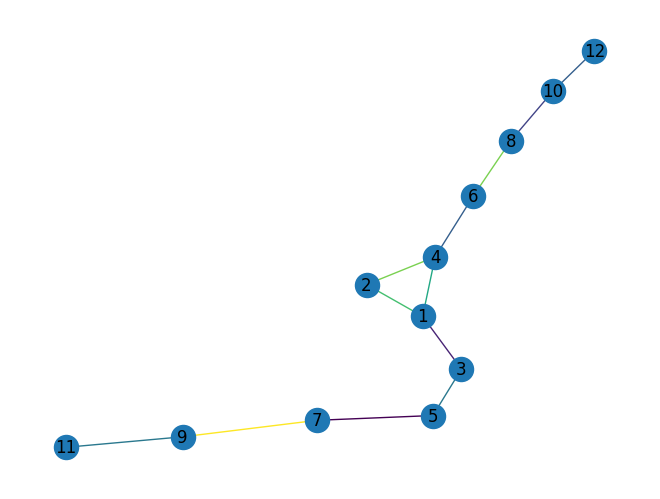

Time taken: 0.16296768188476562 seconds

Running test graph_12_edges_2.txt...
Best Coloring: [ 9  2 11  1  0  8  7  8  7  9  2  2]
Best Value: 0
Number of Colors: 7
[ 9  2 11  1  0  8  7  8  7  9  2  2]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


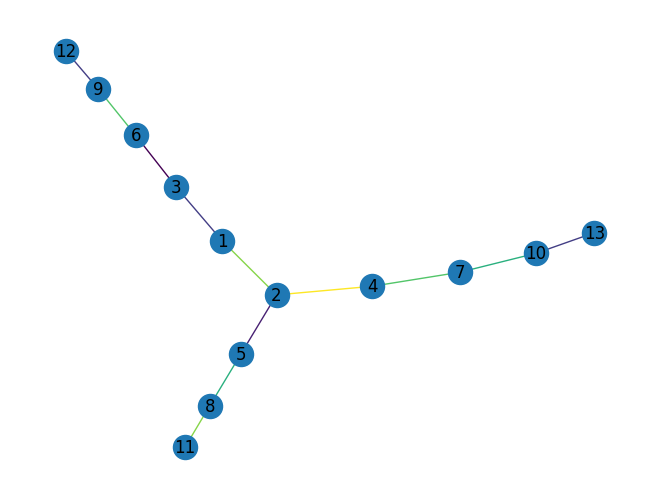

Time taken: 0.19913363456726074 seconds

Running test graph_15_edges.txt...
Best Coloring: [6 5 2 0 4 8 4 8 7 1 0 6 3 8 1]
Best Value: 0
Number of Colors: 9
[6 5 2 0 4 8 4 8 7 1 0 6 3 8 1]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 9


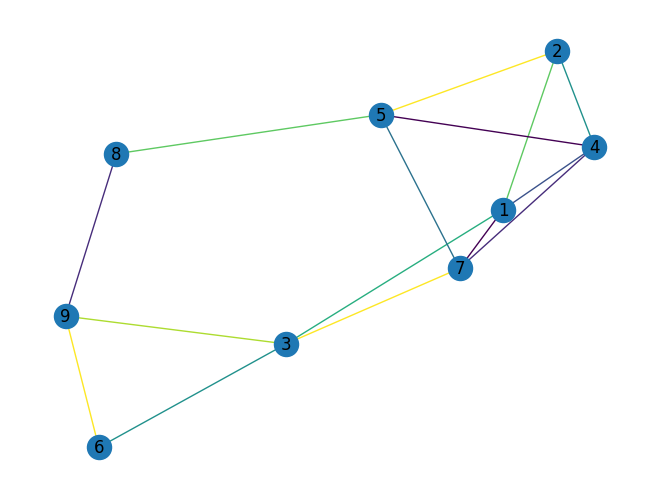

Time taken: 0.6737666130065918 seconds



In [9]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    num_ants = 10
    num_iterations = 100 
    
    alpha = 1
    beta = 1
    evaporation_rate = 0.2
    pheromone_deposit = 1
    
    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_coloring, best_value, num_colors = ant_colony_optimization(graph, num_ants, num_iterations, alpha, beta, evaporation_rate, pheromone_deposit)
            end_time = time.time()
            print("Best Coloring:", best_coloring)
            print("Best Value:", best_value)
            print("Number of Colors:", num_colors)
            write_output(graph, file, best_coloring, num_colors, start_time, end_time)

run_tests('./tests')